# Pre-Processing and Modeling

# 1. Contents
* [Pre-Processing and Modeling](#Pre-Processing_and_Modeling)
    * [1. Contents](#1._Contents)

# 2. Sourcing and Loading

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import pickle
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [5]:
df = pd.read_csv('df.csv', index_col=0, parse_dates=['date'])
df.head()

,id,gender,age,industry,sign,date,blog
0,1000331,female,37,Unknown,Leo,2004-05-31,"Well, everyone got up and going this morning. ..."
1,1000331,female,37,Unknown,Leo,2004-05-29,My four-year old never stops talking. She'll ...
2,1000331,female,37,Unknown,Leo,2004-05-28,"Actually it's not raining yet, but I bought 15..."
3,1000331,female,37,Unknown,Leo,2004-05-28,Ha! Just set up my RSS feed - that is so easy!...
4,1000331,female,37,Unknown,Leo,2004-05-28,"Oh, which just reminded me, we were talking ab..."


In [6]:
df.dtypes

id                   int64
gender              object
age                  int64
industry            object
sign                object
date        datetime64[ns]
blog                object
dtype: object

# 3. Pre-Processing

### 3a. Convert text to lowercase

In [7]:
df['blog'] = [blog.lower() for blog in tqdm(df['blog'], position=0, leave=True)]
df.head()

100%|██████████████████████████████████████████████████████████████████████| 598418/598418 [00:02<00:00, 233240.55it/s]


,id,gender,age,industry,sign,date,blog
0,1000331,female,37,Unknown,Leo,2004-05-31,"well, everyone got up and going this morning. ..."
1,1000331,female,37,Unknown,Leo,2004-05-29,my four-year old never stops talking. she'll ...
2,1000331,female,37,Unknown,Leo,2004-05-28,"actually it's not raining yet, but i bought 15..."
3,1000331,female,37,Unknown,Leo,2004-05-28,ha! just set up my rss feed - that is so easy!...
4,1000331,female,37,Unknown,Leo,2004-05-28,"oh, which just reminded me, we were talking ab..."


## 3b. Remove numbers

In [8]:
df['blog'] = [re.sub(r'\d+', '', blog) for blog in tqdm(df['blog'], position=0, leave=True)]
df.head()

100%|███████████████████████████████████████████████████████████████████████| 598418/598418 [00:17<00:00, 34659.89it/s]


,id,gender,age,industry,sign,date,blog
0,1000331,female,37,Unknown,Leo,2004-05-31,"well, everyone got up and going this morning. ..."
1,1000331,female,37,Unknown,Leo,2004-05-29,my four-year old never stops talking. she'll ...
2,1000331,female,37,Unknown,Leo,2004-05-28,"actually it's not raining yet, but i bought t..."
3,1000331,female,37,Unknown,Leo,2004-05-28,ha! just set up my rss feed - that is so easy!...
4,1000331,female,37,Unknown,Leo,2004-05-28,"oh, which just reminded me, we were talking ab..."


## 3c. Remove punctuation

In [9]:
df['blog'] = [blog.translate(str.maketrans('','', string.punctuation)) for blog in tqdm(df['blog'], position=0, leave=True)]
df.head()

100%|███████████████████████████████████████████████████████████████████████| 598418/598418 [00:16<00:00, 37255.94it/s]


,id,gender,age,industry,sign,date,blog
0,1000331,female,37,Unknown,Leo,2004-05-31,well everyone got up and going this morning i...
1,1000331,female,37,Unknown,Leo,2004-05-29,my fouryear old never stops talking shell say...
2,1000331,female,37,Unknown,Leo,2004-05-28,actually its not raining yet but i bought tic...
3,1000331,female,37,Unknown,Leo,2004-05-28,ha just set up my rss feed that is so easy w...
4,1000331,female,37,Unknown,Leo,2004-05-28,oh which just reminded me we were talking abou...


### 3d. Remove whitespaces

In [10]:
df['blog'] = [blog.strip() for blog in df['blog']]
df.head()

,id,gender,age,industry,sign,date,blog
0,1000331,female,37,Unknown,Leo,2004-05-31,well everyone got up and going this morning i...
1,1000331,female,37,Unknown,Leo,2004-05-29,my fouryear old never stops talking shell say...
2,1000331,female,37,Unknown,Leo,2004-05-28,actually its not raining yet but i bought tic...
3,1000331,female,37,Unknown,Leo,2004-05-28,ha just set up my rss feed that is so easy w...
4,1000331,female,37,Unknown,Leo,2004-05-28,oh which just reminded me we were talking abou...


### 3e. One-Hot Encoding

In [11]:
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
df.head()

,id,age,industry,sign,date,blog,gender_male
0,1000331,37,Unknown,Leo,2004-05-31,well everyone got up and going this morning i...,0
1,1000331,37,Unknown,Leo,2004-05-29,my fouryear old never stops talking shell say...,0
2,1000331,37,Unknown,Leo,2004-05-28,actually its not raining yet but i bought tic...,0
3,1000331,37,Unknown,Leo,2004-05-28,ha just set up my rss feed that is so easy w...,0
4,1000331,37,Unknown,Leo,2004-05-28,oh which just reminded me we were talking abou...,0


# 4. Modeling

### 4a. Random Forest Classifier

In [12]:
grid_params = {'tfidfvectorizer__stop_words': ['english', None]}
grid_params

{'tfidfvectorizer__stop_words': ['english', None]}

In [89]:
%%time

rf_pipe = make_pipeline(TfidfVectorizer(stop_words='english', min_df=0.01), 
                        StandardScaler(with_mean=False), 
                        RandomForestClassifier())

X = df[df['age']<20]['blog']
y = df[df['age']<20]['gender_male']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

teens_rf_grid = GridSearchCV(rf_pipe, param_grid=grid_params, cv=5, verbose=1, n_jobs=-1)
teens_rf_model = teens_rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 117.1min finished


Wall time: 2h 32min 35s


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AUC: 0.718
Wall time: 37.8 s


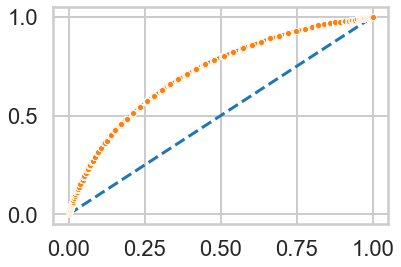

In [93]:
%%time

probs = teens_rf_model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
sns.lineplot([0,1], [0,1], linestyle='--')
plt = sns.lineplot(x=fpr, y=tpr, marker='.')
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

In [98]:
pickle.dump(teens_rf_model, open('teens_rf_model.sav', 'wb'))

### 4b. XGBoost Classifier

In [13]:
%%time

rf_pipe = make_pipeline(TfidfVectorizer(stop_words='english', min_df=0.01), 
                        StandardScaler(with_mean=False), 
                        XGBClassifier())

X = df[df['age']<20]['blog']
y = df[df['age']<20]['gender_male']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

teens_xg_grid = GridSearchCV(rf_pipe, param_grid=grid_params, cv=5, verbose=1, n_jobs=-1)
teens_xg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 34.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 40min 30s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(min_df=0.01,
                                                        stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      in

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AUC: 0.744
Wall time: 3min 17s


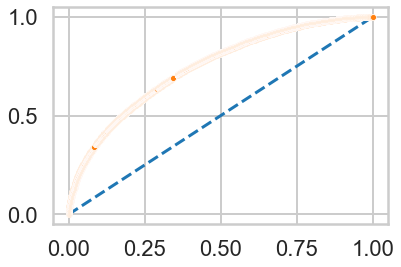

In [14]:
%%time

probs = teens_xg_grid.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
sns.lineplot(x=[0,1], y=[0,1], linestyle='--')
plt = sns.lineplot(x=fpr, y=tpr, marker='.')
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

In [15]:
pickle.dump(teens_xg_grid, open('teens_xg_grid.sav', 'wb'))